In [1]:
!ls ../data/*.csv

../data/small_group_description.csv  ../data/train_target.csv
../data/test.csv		     ../data/transactions_test.csv
../data/test_ids_file.csv	     ../data/transactions_train.csv


# Data Preparation

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [3]:
import sys

In [4]:
sys.path.append('../../../')

In [5]:
df_trx = pd.concat([
    pd.read_csv('../data/transactions_train.csv'),
    pd.read_csv('../data/transactions_test.csv'),        
], axis=0)

In [6]:
df_trx.head()

,client_id,trans_date,small_group,amount_rur
0,33172,6,4,71.463
1,33172,6,35,45.017
2,33172,8,11,13.887
3,33172,9,11,15.983
4,33172,10,11,21.341


In [7]:
s_all_targets = df_trx.groupby('trans_date')['amount_rur'].sum().sort_index()

In [8]:
assert (np.diff(s_all_targets.index.values) == 1).all()

In [9]:
s_all_targets = s_all_targets.rolling(window=7).sum().shift(-7)

In [10]:
s_all_targets

trans_date
0      1.852190e+07
1      1.814066e+07
2      1.762593e+07
3      1.713446e+07
4      1.659577e+07
           ...     
725             NaN
726             NaN
727             NaN
728             NaN
729             NaN
Name: amount_rur, Length: 730, dtype: float64

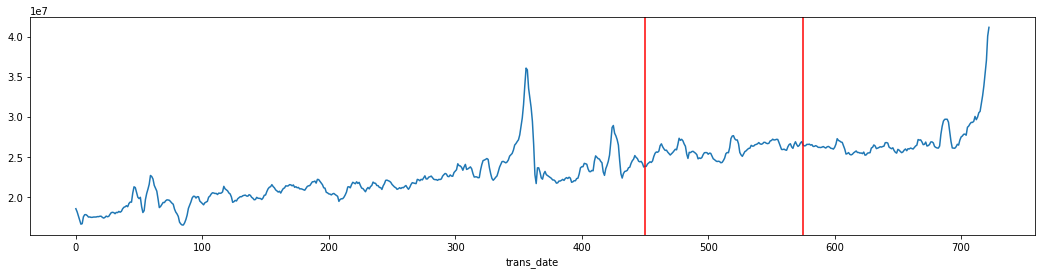

In [11]:
s_all_targets.plot(figsize=(18, 4))
plt.axvline(450, color='red')
plt.axvline(575, color='red')
plt.show()

In [12]:
df_trx[lambda x: x['trans_date'] < 450] \
    ['small_group'].value_counts(normalize=True).cumsum()[lambda x: x <= 0.99].size

75

In [13]:
used_small_group = df_trx[lambda x: x['trans_date'] < 450]['small_group'].value_counts().index.tolist()[:70]

In [41]:
df_features = df_trx[lambda x: x['small_group'].isin(used_small_group)].pivot_table(
    index='trans_date',
    columns='small_group',
    values='amount_rur',
    aggfunc=[len, 'sum', 'std'],
).reindex(s_all_targets.index).fillna(0)

In [42]:
df_features = df_features.rolling(window=7).sum()

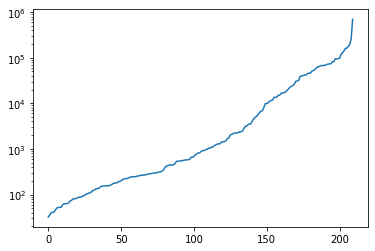

In [46]:
df_features.loc[:450].std().sort_values().reset_index(drop=True).plot(logy=True)
plt.show()

In [47]:
df_features = df_features / df_features.loc[:450].std()

In [48]:
df_features.shape

(730, 210)

In [49]:
df_features

len                                                        \
small_group        0          1          2          3          4         5     
trans_date                                                                     
0                  NaN        NaN        NaN        NaN        NaN       NaN   
1                  NaN        NaN        NaN        NaN        NaN       NaN   
2                  NaN        NaN        NaN        NaN        NaN       NaN   
3                  NaN        NaN        NaN        NaN        NaN       NaN   
4                  NaN        NaN        NaN        NaN        NaN       NaN   
...                ...        ...        ...        ...        ...       ...   
725          10.743783  12.699403  10.063298  16.397569   9.723233  8.909009   
726          11.283671  12.723957  10.075071  16.670233   9.899757  9.049554   
727          11.617727  12.872493  10.298746  17.093196  10.254502  9.400917   
728          12.650264  13.167834  10.928914  17.416847  10.707268  9.549271   
729          13.048432  13.240545  11.016168  17.509952  10.614338  9.330645   

                                                        ...       std  \
small_group       6          7          8          9    ...       76    
trans_date                                              ...             
0                 NaN        NaN        NaN        NaN  ...       NaN   
1                 NaN        NaN        NaN        NaN  ...       NaN   
2                 NaN        NaN        NaN        NaN  ...       NaN   
3                 NaN        NaN        NaN        NaN  ...       NaN   
4                 NaN        NaN        NaN        NaN  ...       NaN   
...               ...        ...        ...        ...  ...       ...   
725          4.347317   9.295120   8.729905  14.816818  ...  2.436032   
726          4.791568   9.654077   9.286183  15.154007  ...  2.354303   
727          5.219953  10.315316   9.675983  15.651660  ...  2.409350   
728          5.997393  10.447563  10.256624  16.509270  ...  2.045578   
729          6.394046   9.937465  10.833203  16.830196  ...  1.840517   

                                                                          \
small_group        77        78        80        82        83        91    
trans_date                                                                 
0                  NaN       NaN       NaN       NaN       NaN       NaN   
1                  NaN       NaN       NaN       NaN       NaN       NaN   
2                  NaN       NaN       NaN       NaN       NaN       NaN   
3                  NaN       NaN       NaN       NaN       NaN       NaN   
4                  NaN       NaN       NaN       NaN       NaN       NaN   
...                ...       ...       ...       ...       ...       ...   
725           6.705503  3.620711  0.791012  2.225555  3.515149  2.906552   
726           8.395783  3.527158  1.449344  2.160747  3.353754  2.843104   
727          10.091709  3.728977  1.532691  2.276371  3.408807  2.907316   
728           9.303258  3.962740  2.319971  2.069497  3.001154  2.980312   
729           8.807000  3.974905  3.606505  2.019007  2.685821  2.469036   

                                           
small_group       106       109       115  
trans_date                                 
0                 NaN       NaN       NaN  
1                 NaN       NaN       NaN  
2                 NaN       NaN       NaN  
3                 NaN       NaN       NaN  
4                 NaN       NaN       NaN  
...               ...       ...       ...  
725          3.923425  0.720551  0.841714  
726          3.923766  0.666139  0.925154  
727          5.290044  0.622769  1.037681  
728          5.217800  0.870128  1.163170  
729          5.456043  0.895465  1.316172  

[730 rows x 210 columns]

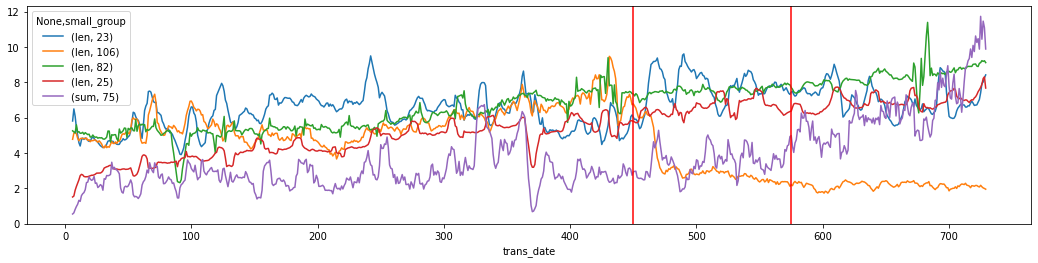

In [50]:
df_features.iloc[:, np.random.choice(df_features.shape[1], 5, replace=False)].plot(figsize=(18, 4))
plt.axvline(450, color='red')
plt.axvline(575, color='red')
plt.show()

# Stream Encoder

In [51]:
df_se_train = df_features.iloc[7 - 1:].loc[:450]

In [52]:
df_se_train

len                                                        \
small_group       0          1         2          3          4          5     
trans_date                                                                    
6            4.936606   6.470440  7.157601  15.198731   4.880287   5.684276   
7            5.695824   6.953396  7.766301  14.711481   5.245640   5.653043   
8            5.719445   7.194182  7.672815  14.998333   5.449322   5.980982   
9            5.739690   7.386378  7.475455  15.201834   5.649608   6.363578   
10           5.712696   7.565865  7.284327  15.404448   5.854987   6.832062   
...               ...        ...       ...        ...        ...        ...   
446          9.596519  12.195007  9.451135  16.871074  10.066521  11.071845   
447          9.724743  12.267026  9.497532  16.939351  10.114895  11.126501   
448          9.674128  12.247573  9.570936  16.964623  10.107681  11.157733   
449          9.721369  12.301091  9.578554  17.196055  10.106833  11.407592   
450          9.535782  12.235123  9.476757  17.405320  10.038939  11.056228   

                                                      ...       std            \
small_group       6         7         8          9    ...       76        77    
trans_date                                            ...                       
6            3.522278  1.757004  6.098752   9.686335  ...  2.104505  2.128913   
7            3.760270  1.851467  6.614426  10.536356  ...  1.410556  2.170002   
8            3.871333  2.134855  6.078450  10.475640  ...  4.218034  1.902261   
9            3.807869  2.285995  5.453146  10.244703  ...  4.192488  1.933258   
10           3.807869  2.626060  4.978076  10.121103  ...  4.196302  1.951993   
...               ...       ...       ...        ...  ...       ...       ...   
446          3.189090  7.481438  5.924154  11.155440  ...  1.625608  4.128768   
447          3.204956  7.727040  5.855127  11.208566  ...  2.015481  4.025618   
448          3.220822  7.878181  5.997242  11.286629  ...  1.942593  4.039355   
449          3.109759  7.934858  6.037846  11.357103  ...  2.360181  2.976745   
450          3.157358  7.764826  5.952577  11.209650  ...  2.371771  3.551064   

                                                                         \
small_group       78        80        82        83        91        106   
trans_date                                                                
6            3.662247  1.141331  1.184386  2.629371  1.045932  1.653876   
7            3.289946  1.183787  0.906590  2.958851  1.030109  1.653602   
8            3.606747  0.624337  0.992071  2.615569  1.070319  2.286743   
9            3.879897  0.699785  0.870607  2.545469  1.094258  2.116478   
10           3.788210  0.782228  0.883549  2.778149  1.261871  2.420600   
...               ...       ...       ...       ...       ...       ...   
446          4.282996  0.801740  0.345026  3.174380  1.173570  3.247502   
447          4.027310  0.872226  0.350401  3.192121  1.241419  3.272353   
448          3.954848  0.790922  0.304537  3.787361  1.791857  3.378616   
449          3.714056  0.712988  0.316008  4.093746  2.266124  1.748919   
450          4.090153  1.133171  0.328893  3.421576  2.315674  1.654742   

                                 
small_group       109       115  
trans_date                       
6            1.138191  0.673888  
7            0.779666  1.015311  
8            0.740898  1.051580  
9            0.800830  1.282892  
10           0.820981  1.257368  
...               ...       ...  
446          5.500898  0.559629  
447          5.926097  0.556062  
448          5.507090  0.884574  
449          5.137260  0.842013  
450          4.182433  0.824845  

[445 rows x 210 columns]

In [53]:
from dltranz.lightning_modules.stream_encoder import StreamEncoder, Loader3DTensor

import torch
import pytorch_lightning as pl

In [54]:
stream_encoder = StreamEncoder(
    history_size=21, predict_size=14, predict_lag=7,
    in_channels=210, clip_range=(-3, 3),
    h_channels=32, p_dropout=0, z_channels=16,
    c_channels=48,
    var_gamma_z=0.5, var_gamma_c=0.2,
    lr=0.001, weight_decay=0,
    step_size=10, gamma=0.9,
    cpc_w=0.1,
    cov_z_w=0.1, var_z_w=0.1,
    cov_c_w=0.1, var_c_w=0.1,
)

In [55]:
l3dt = Loader3DTensor(stream_encoder)
dl_train = l3dt.get_train_dataloader(torch.from_numpy(df_se_train.values).unsqueeze(0).float()[:, :, :], 32, 4)
dl_valid = l3dt.get_valid_dataloader(torch.from_numpy(df_se_train.values).unsqueeze(0).float()[:, :, :], 32, 0)

In [56]:
len(dl_train), len(dl_valid)

(13, 1)

In [57]:
next(iter(dl_train))[0].shape, next(iter(dl_valid))[0].shape

(torch.Size([32, 35, 210]), torch.Size([1, 445, 210]))

In [58]:
trainer = pl.Trainer(
    gpus=[3],
    max_epochs=100,
    log_every_n_steps=4,
    progress_bar_refresh_rate=50, weights_summary=None,
    logger=pl.loggers.TensorBoardLogger(
        save_dir='lightning_logs/',
        default_hp_metric=False,
    )
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [63]:
trainer.fit(stream_encoder, train_dataloader=dl_train, val_dataloaders=dl_valid)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
Missing logger folder: lightning_logs/default


Validation sanity check: 0it [00:00, ?it/s]

/mnt2/kireev/pipenv_envs/pytorch-lifestream-bcSZKFyz/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

# Tuning

In [64]:
def r_exp(b, m):
    a = b / m
    b = b * m
    a = np.log(a)
    b = np.log(b)
    
    return np.exp(np.random.random(1)[0] * (b - a) + a)

In [65]:
best_model = StreamEncoder.load_from_checkpoint(
    'lightning_logs/default/version_0/checkpoints/epoch=99-step=1299.ckpt')

In [67]:
mul_c = 100.0
for i in range(10):
    params = dict(
        lr=r_exp(best_model.hparams.lr, mul_c),
        weight_decay=0.0 if np.random.random(1)[0] > 0.5 else r_exp(0.001, mul_c),
        cpc_w=0.1,
        cov_z_w=r_exp(best_model.hparams.cov_z_w, mul_c),
        var_z_w=r_exp(best_model.hparams.var_z_w, mul_c),
        cov_c_w=r_exp(best_model.hparams.cov_c_w, mul_c),
        var_c_w=r_exp(best_model.hparams.var_c_w, mul_c),
        z_channels=np.random.choice(np.arange(2, 20, 2), 1)[0],
        p_dropout=0 if np.random.random(1)[0] > 0.5 else np.random.random() / 10,
    )
    print(f'[{i:04d}] - start', end='')
    stream_encoder = StreamEncoder(  
        history_size=21, predict_size=14, predict_lag=7,
        in_channels=210, clip_range=(-3, 3),
        h_channels=params['z_channels'] * 2,
        c_channels=48,
        var_gamma_z=0.5, var_gamma_c=0.2,
        step_size=10, gamma=0.9,
        **params,
    )
    trainer = pl.Trainer(
        gpus=[3],
        max_epochs=100,
        log_every_n_steps=4,
        progress_bar_refresh_rate=0, weights_summary=None,
        logger=pl.loggers.TensorBoardLogger(
            save_dir='lightning_logs/',
            default_hp_metric=False,
        )
    )

    trainer.fit(stream_encoder, train_dataloader=dl_train, val_dataloaders=dl_valid)
    print(' - done')

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


[0000] - start

/mnt2/kireev/pipenv_envs/pytorch-lifestream-bcSZKFyz/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


 - done
[0001] - start

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


 - done
[0002] - start

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


 - done
[0003] - start

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


 - done
[0004] - start

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


 - done
[0005] - start

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


 - done
[0006] - start

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


 - done
[0007] - start

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


 - done
[0008] - start

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


 - done
[0009] - start - done


# Eval

In [68]:
model = StreamEncoder.load_from_checkpoint('lightning_logs/default/version_0/checkpoints/epoch=99-step=1299.ckpt')
print(model.hparams)

"c_channels":   48
"clip_range":   (-3, 3)
"cov_c_w":      0.1
"cov_z_w":      0.1
"cpc_w":        0.1
"gamma":        0.9
"h_channels":   32
"history_size": 21
"in_channels":  210
"lr":           0.001
"p_dropout":    0
"predict_lag":  7
"predict_size": 14
"step_size":    10
"var_c_w":      0.1
"var_gamma_c":  0.2
"var_gamma_z":  0.5
"var_z_w":      0.1
"weight_decay": 0
"z_channels":   16


In [69]:
pred_horizon = 11
model.eval()

data_norm, z, c = model(torch.from_numpy(df_se_train.values).unsqueeze(0).float()[:, :, :])
p = model.lin_predictors_c2p[pred_horizon - 1 - model.hparams.predict_lag](c)

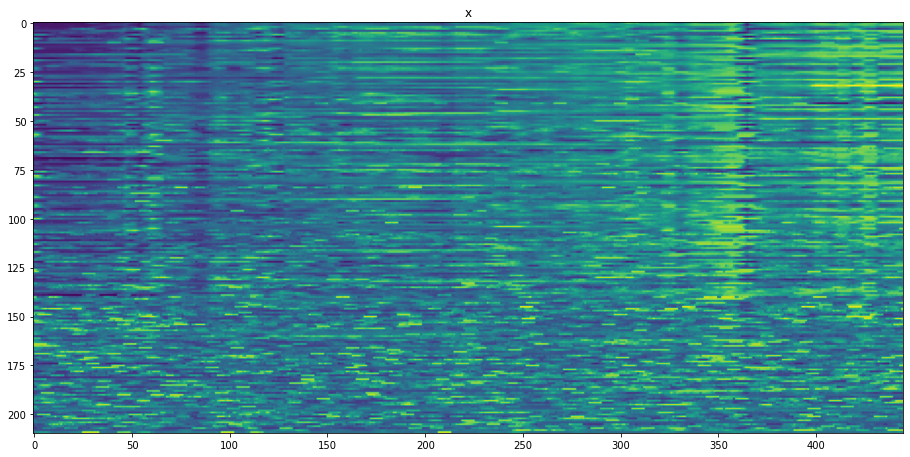

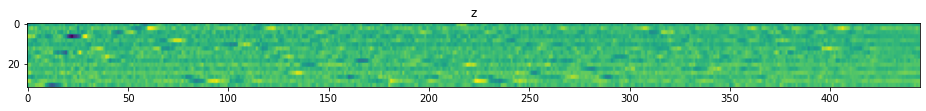

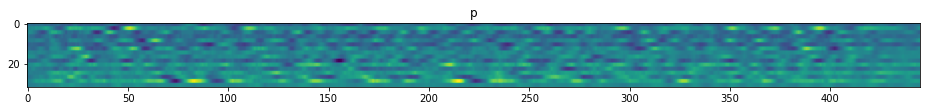

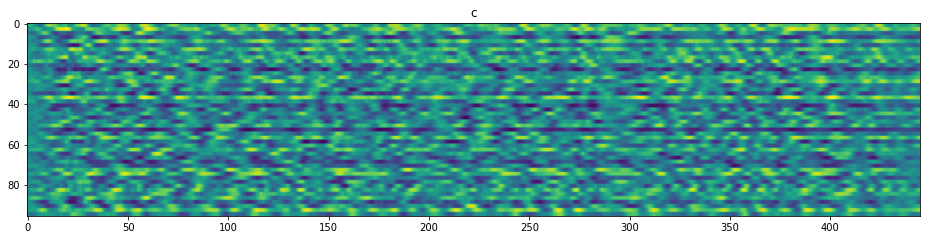

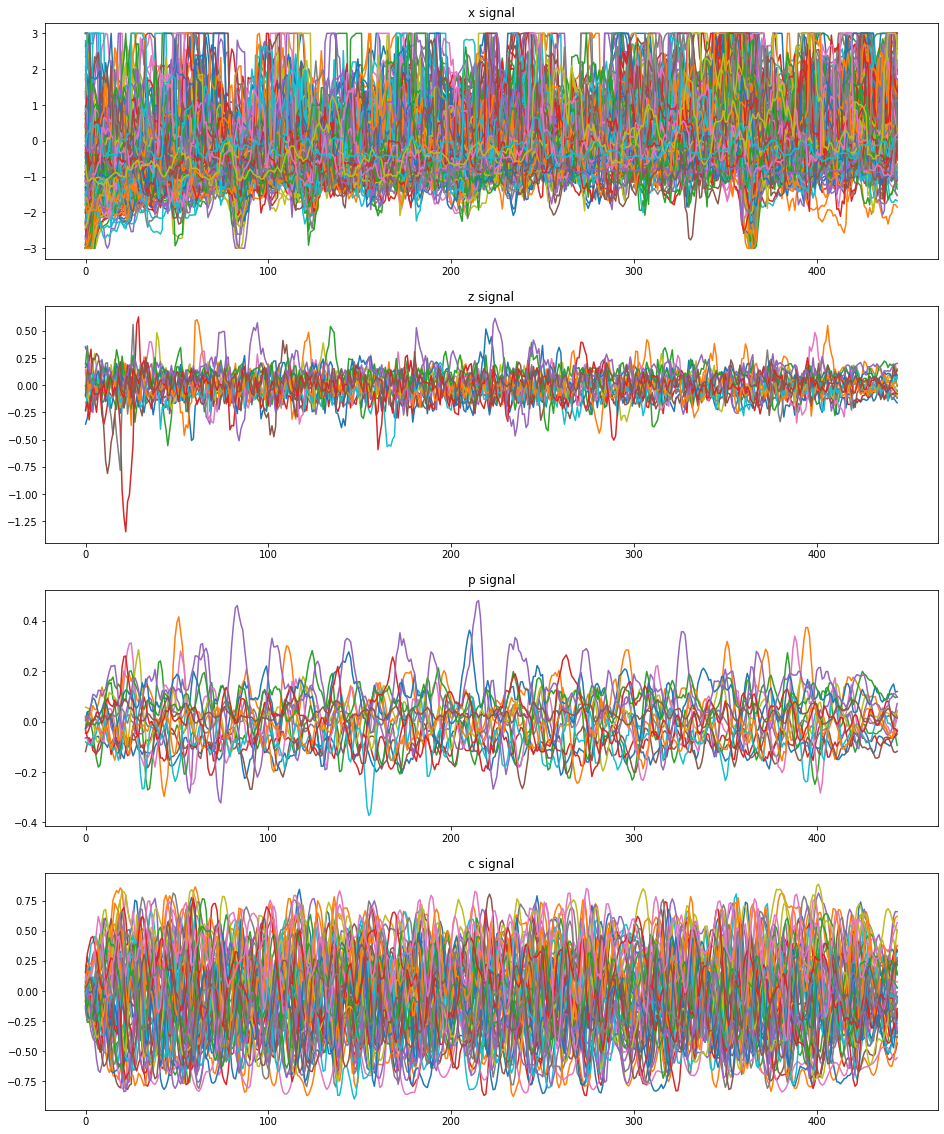

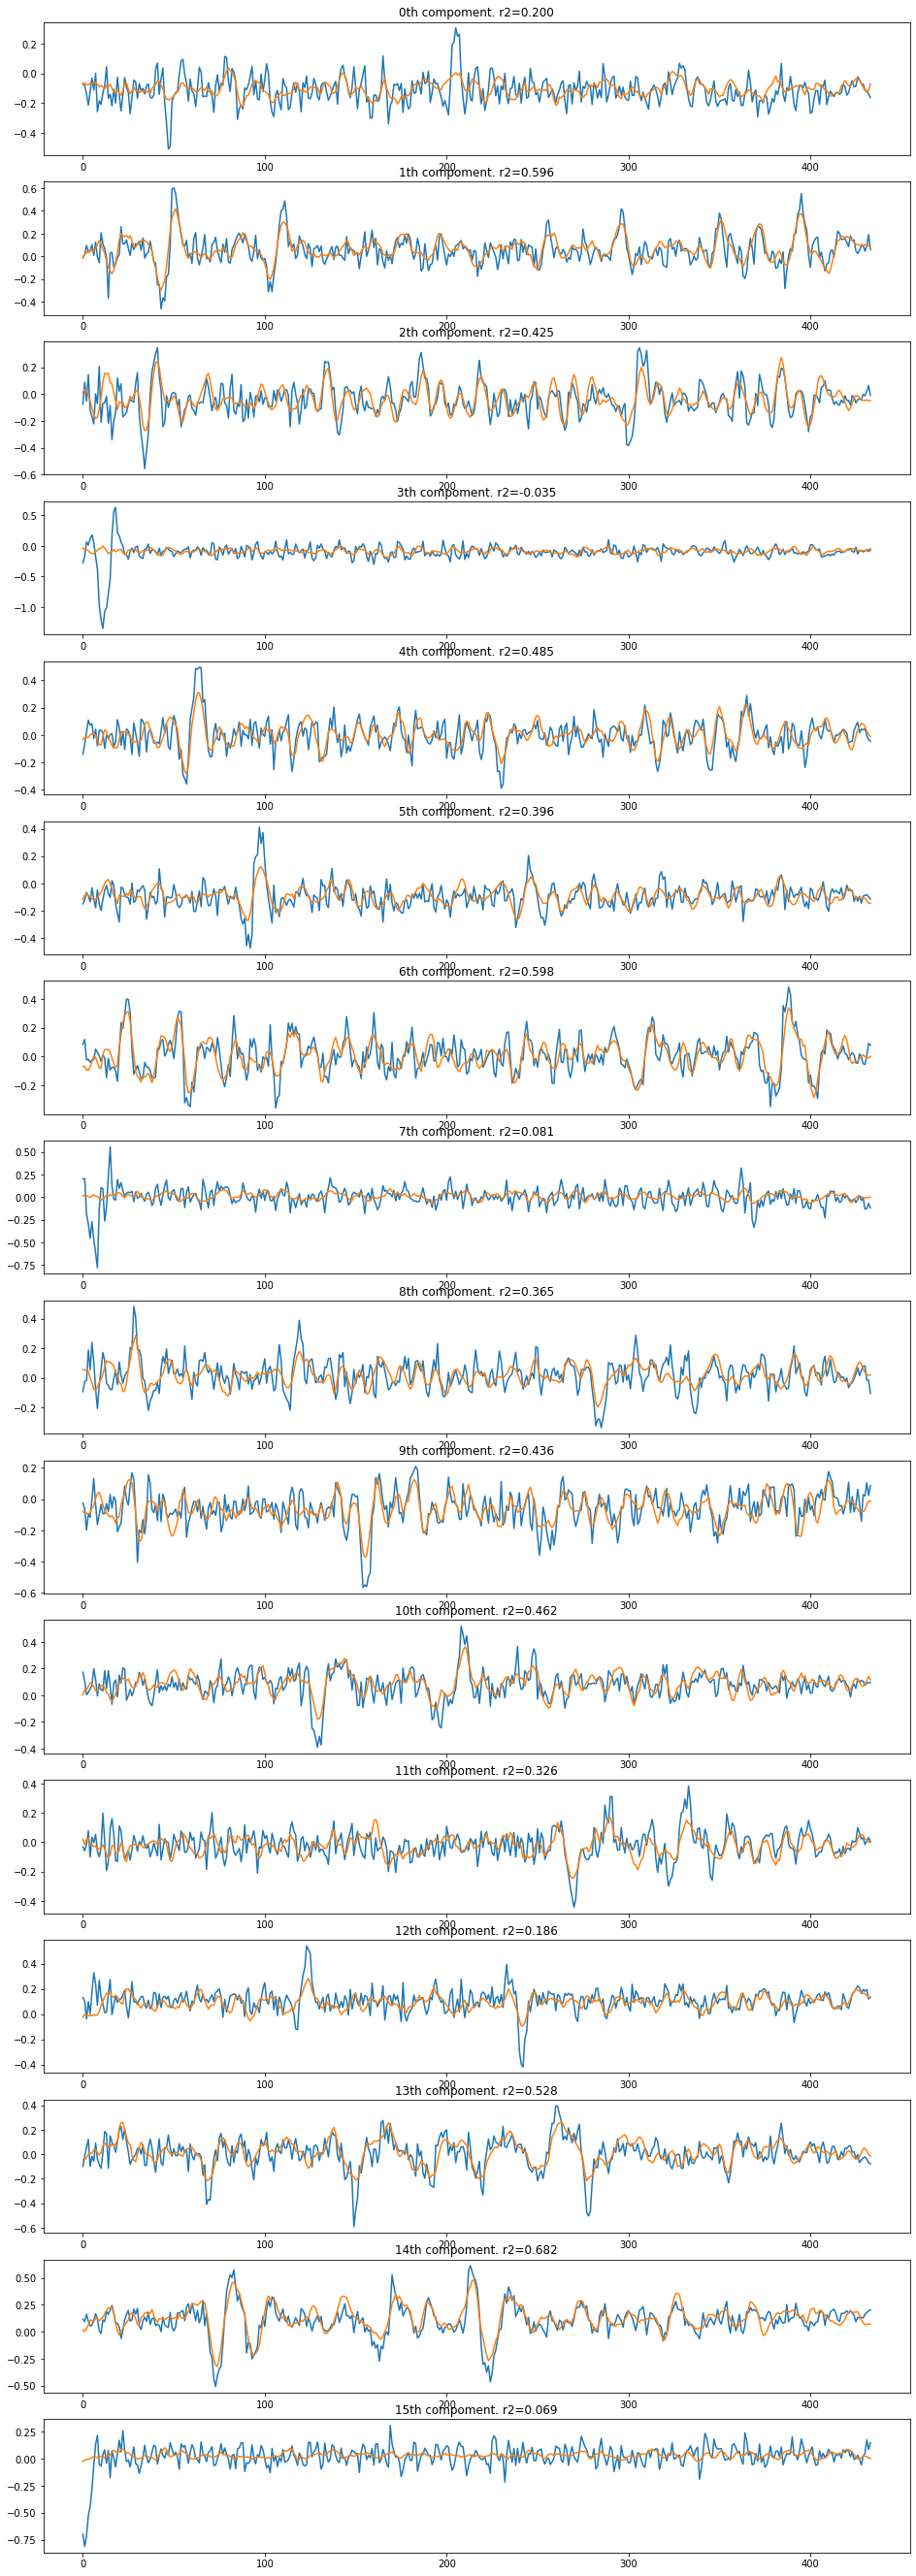

r2_score = 0.362
z_self_corr = 0.026
z_unique_features = 11.389
cpc_pow = 4.126


In [70]:
data_norm, z, c, p = [t for t in [data_norm, z, c, p]]

#%%

a = data_norm[0].detach().numpy()
plt.figure(figsize=(16, 16 * a.shape[1] / a.shape[0]))
plt.imshow(np.clip(a, *np.quantile(a, [0.05, 0.95], axis=0)).T)
plt.title('x')
plt.show()

a = z.unsqueeze(-1).repeat(1, 1, 1, 2).view(*z.size()[:-1], -1)[0].detach().numpy()
plt.figure(figsize=(16, 16 * 2 * a.shape[1] / a.shape[0]))
plt.imshow(a.T)
plt.title('z')
plt.show()

a = p.unsqueeze(-1).repeat(1, 1, 1, 2).view(*z.size()[:-1], -1)[0].detach().numpy()
plt.figure(figsize=(16, 16 * 2 * a.shape[1] / a.shape[0]))
plt.imshow(a.T)
plt.title('p')
plt.show()

a = c.unsqueeze(-1).repeat(1, 1, 1, 2).view(*z.size()[:-1], -1)[0].detach().numpy()
plt.figure(figsize=(16, 16 * 2 * a.shape[1] / a.shape[0]))
plt.imshow(a.T)
plt.title('c')
plt.show()

_, axs = plt.subplots(4, 1, figsize=(16, 5 * 4))
axs[0].plot(data_norm[0].detach().numpy())
axs[0].set_title('x signal')
axs[1].plot(z[0].detach().numpy())
axs[1].set_title('z signal')
axs[2].plot(p[0].detach().numpy())
axs[2].set_title('p signal')
axs[3].plot(c[0].detach().numpy())
axs[3].set_title('c signal')
plt.show()


_, axs = plt.subplots(z.size(2), 1, figsize=(16, 3 * z.size(2)))
for i, ax in zip(range(z.size(2)), axs):
    ax.plot(z[0, pred_horizon:, i].detach().numpy())
    ax.plot(p[0, :-pred_horizon, i].detach().numpy())
    r2_score = torch.where(
        z[0, 7 + pred_horizon:, i].var() * (z.size(1) - pred_horizon) > 1e-6,
        1 - (z[0, pred_horizon:, i] - p[0, :-pred_horizon, i]).pow(2).sum() / 
            z[0, pred_horizon:, i].var() / (z.size(1) - pred_horizon),
        torch.tensor([0.0]),
    )
    ax.set_title(f'{i}th compoment. r2={r2_score.item():.3f}')
plt.show()

r2_score = torch.where(
    z[:, pred_horizon:, :].var(dim=1) / (z.size(1) - pred_horizon) > 1e-6,
    1 - (z[:, pred_horizon:] - p[:, :-pred_horizon]).pow(2).sum(dim=1) / 
        z[:, pred_horizon:, :].var(dim=1) / (z.size(1) - pred_horizon),
    torch.tensor([0.0]),
)
print(f'r2_score = {r2_score.mean():.3f}')

_z = (z - z.mean(dim=1, keepdims=True)) / (z.std(dim=1, keepdims=True) + 1e-6)
mc = torch.bmm(_z.transpose(1, 2), _z).abs() / _z.size(1)
C = mc.size(1)
off_diag_ix = (1 - torch.eye(C)).bool().view(-1)
m = mc.view(-1, C * C)[:, off_diag_ix].mean()
print(f'z_self_corr = {m:.3f}')
print(f'z_unique_features = {1 / (mc.mean() + 1e-3):.3f}', )
print(f'cpc_pow = {r2_score.mean() / (mc.mean() + 1e-3):.3f}')

# Inference